<a href="https://colab.research.google.com/github/RuslanMavlitov/sf_data_science/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Финальный проект

In [143]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Анализ данных

### Данные логов событий

In [ ]:
#Загрузим данные лога событий
events = pd.read_csv('/content/drive/MyDrive/SF/Final_prj/data/events.csv.zip')
print(events.info())
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


**events** — датасет с событиями. 

Колонки:

**timestamp** — время события

**visitorid** — идентификатор пользователя

**event** — тип события

**itemid** — идентификатор объекта

transactionid — идентификатор транзакции, если она проходила

In [148]:
#Метку веремени ("timestamp") переведем в формат времени.
events.timestamp = pd.to_datetime(events.timestamp, unit='ms', origin='unix')
events.head(2)

,timestamp,visitorid,event,itemid,transactionid,top
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,0
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,0


In [ ]:
print(f' Лог событий взят за период с {events.timestamp.min()} по {events.timestamp.max()}')

 Лог событий взят за период с 2015-05-03 03:00:04.384000 по 2015-09-18 02:59:47.788000


In [150]:
events['day_of_week'] = events['timestamp'].map(lambda x: x.weekday())
events['Year'] = events['timestamp'].map(lambda x: x.year)
events['Month'] = events['timestamp'].map(lambda x: x.month)
events['Day'] = events['timestamp'].map(lambda x: x.day)
events['Hour'] = events['timestamp'].map(lambda x: x.hour)
events['minute'] = events['timestamp'].map(lambda x: x.minute)

In [151]:
def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
events['Day Period'] = events['Hour'].map(get_time_periods)
events['Day Period'].value_counts()

Evening      1078199
Night         765924
Dawn          494588
Afternoon     293490
Morning       123900
Name: Day Period, dtype: int64

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

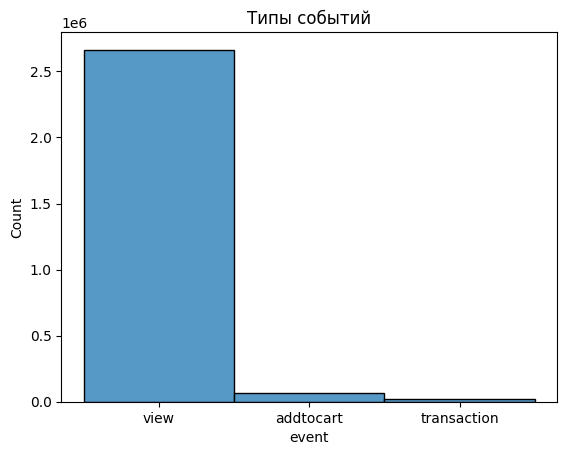

In [ ]:
#Какие типы событий содержатся в датасете?
sns.histplot(events.event).set_title('Типы событий')
events.event.value_counts()

возьмём статистику до 1 июля включительно и потом прикинем, как эти товары покупались после 1 июля.

In [152]:
#Разделим данные с транзакциями на 2 части (до 1 июля и после)
df_1 = events.query('event=="transaction"  & timestamp<20150702').copy()
df_2 = events.query('event=="transaction" & timestamp>=20150702').copy()

In [153]:
#Найдем ТОП-3 товаров по количеству транзакций
top_items = list(events[events.event=="transaction"].itemid.value_counts()[:3].index)
print(f' В ТОП-3 товаров входят {top_items}')

 В ТОП-3 товаров входят [461686, 119736, 213834]


In [154]:
#Создадим колонку "TOP", где будет метка "1" - товар из ТОП-3, иначе "0"
df_1['top'] = df_1.itemid.apply(lambda x: 1 if x in top_items else 0)
df_2['top'] = df_2.itemid.apply(lambda x: 1 if x in top_items else 0)
events['top'] = events.itemid.apply(lambda x: 1 if x in top_items else 0)

In [155]:
df_1['top'].value_counts(normalize=True)*100

0    99.370494
1     0.629506
Name: top, dtype: float64

In [156]:
train, test = train_test_split(events, test_size=0.3, shuffle=False)

###Данные дерева категорий товаров

In [ ]:
#Загрузим дерево категорий
category_tree = pd.read_csv('/content/drive/MyDrive/SF/Final_prj/data/category_tree.csv')
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


**category_tree** — файл с деревом категорий (можно восстановить дерево).
_______________________________________________________________________

**category_id** — идентификатор категорий

**parent_id** — идентификатор родительской категории

In [ ]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


###  Данные по свойствам товаров

In [ ]:
#Загрузим данные со свойствами товаров
items_1 = pd.read_csv('/content/drive/MyDrive/SF/Final_prj/data/item_properties_part1.csv.zip')
items_2 = pd.read_csv('/content/drive/MyDrive/SF/Final_prj/data/item_properties_part2.csv.zip')

In [ ]:
print(items_1.info())
items_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB
None


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [ ]:
print(items_2.info())
items_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB
None


,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [ ]:
items = pd.concat([items_1, items_2], axis=0)

**items** — файл с свойствами товаров.
______________________________________

**timestamp** — момент записи значения свойства

**item_id** — идентификатор объекта

**property** — свойство

**value** — значение свойства

In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [144]:
#Сколько уникальных признаков товара есть в датасете?
print(f'Уникальных признаков товаров {items.property.nunique()}')

Уникальных признаков товаров 1104


In [145]:
# Возьмем только самые распространенные proprties, например топ 20 (при построении модели можно играть)
top_properties = items.drop_duplicates(['itemid', 'property']).groupby("property")['itemid'].count().sort_values(ascending=False)[:20]

In [146]:
properties_filtered = items[items['property'].isin(set(top_properties.index))]
properties_filtered.shape

(13563669, 4)

In [147]:
# Далее трансформации стоит делать в соответствии с используемым алгоритмом
properties_filtered.head(10)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
5,1436065200000,285026,available,0
7,1431831600000,264312,6,319724
8,1433646000000,229370,202,1330310
10,1439089200000,450113,888,1038400 45956 n504.000
12,1439694000000,264319,227,1283144 353870
13,1439694000000,348323,839,1026952 1162729


## Откроем на чтение Dockerfile

In [ ]:
with open('/content/Dockerfile', 'r') as f:
  for line in f:
    print(line)

FROM ubuntu:18.04

ENV TZ=Europe/Moscow



ARG VERSION=0.0.1

LABEL "maintainer"="Mikhail Baranov <kinetikm@gmail.com>" \

      "app"="Abtester" \

      "version"="${VERSION}"

      "description"="" \

      "tag"="alpha"



ADDED ./ /app

RUN ln -snf /usr/share/zoneinfo/$TZ /etc/localtime && echo $TZ > /etc/timezone

RUN apt-get update

RUN apt-get install -y software-properties-common vim wget locales

RUN apt-get install -y build-essential python3-pip libpq-dev

RUN apt-get install git wget

    mkdir /logs



RUN sed -i -e 's/# en_US.UTF-8 UTF-8/en_US.UTF-8 UTF-8/' /etc/locale.gen && locale-gen

ENV LANG en_US.UTF-8

ENV LANGUAGE en_US:en

ENV LC_ALL en_US.UTF-8



RUN python3 -m pip install pip --upgrade

RUN python3 -m pip install wheel



RUN python3 -m pip install -r /app/requirements.txt

RUN python3 /app/setup.py install



EXPORT ENV AB_CONFIG=/app/contrib/config.yml



WORKDIR /app

